In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud')

Mounted at /content/drive/


In [ ]:
!pip install open3d
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud/cpp_kd_tree')
!python setup.py build_ext --inplace
import PyKDTree
os.chdir('/content/drive/MyDrive/K-D_Tree_NeRF/diffusion-point-cloud')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running build_ext


In [ ]:
import os
import math
import argparse
import torch
import torch.utils.tensorboard
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

from utils.dataset import *
from utils.misc import *
from utils.data import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from evaluation import *
from models.vae_trained_z import MyVAE

# src_path = '../pcd_gen_results/pcd_gen1_ckpts/GEN_2022_10_14__08_37_36/ckpt_0.000000_629999.pt'
# src_path = '../pcd_gen_results/pcd_gen2_ckpts/GEN_2022_10_14__08_28_48/ckpt_0.000000_629999.pt'
src_path = '../pcd_gen_results/hotdog-chair_1021/ckpt_0.000000_299999.pt'
ckpt = torch.load(src_path)

model = MyVAE(ckpt['args']).cuda()
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
ratios = torch.tensor([0.0, 0.25, 0.375, 0.4375, 0.46875, 0.5, 0.53125, 0.5625, 0.625, 0.75, 1]).cuda()
ratios.shape

torch.Size([11])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num = 4
with torch.no_grad():
  interpolate_samples = model.sample_interpolate(num=2000000, ratios=ratios[5:6])
  print(interpolate_samples.shape)

pts = interpolate_samples.detach().cpu()
del interpolate_samples

np_pcd = pts[0].numpy()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np_pcd[:,0], np_pcd[:,1], np_pcd[:,2])
plt.show()

In [ ]:
def kd_index(points):
  tree = PyKDTree.PyKDTree(points.astype(np.double))
  tree.build(1, 1, points.shape[0], 0)
  index = np.argsort(tree.output_index())

  return index

def order_pts(points, ori_index=None):
  tree = PyKDTree.PyKDTree(points.astype(np.double))
  tree.build(1, 1, points.shape[0], 0)
  index = tree.output_index()
  return_index = ori_index
  if not (return_index is None):
    return_index = return_index[index]

  return points[index], return_index

In [ ]:
np.random.seed(114514)
random_index = np.random.choice(2000000, 2**20, replace=False)
index_0 = np.load('../diffusion-point-cloud/data/PG_hc_index/chair_index.npy')
index_1 = np.load('../diffusion-point-cloud/data/PG_hc_index/hotdog_index.npy')
print(index_0.shape, index_1.shape)

_, ordered_index_0 = order_pts(model.point_clouds[0].detach().cpu().numpy(), index_0)
_, ordered_index_1 = order_pts(model.point_clouds[1].detach().cpu().numpy(), index_1)

(2000000,) (2000000,)


In [ ]:
np_pts = pts.numpy()
pts_0 = np_pts[0]
max_cor = np.max(pts_0, axis=0)
min_cor = np.min(pts_0, axis=0)
eps = 0.2
colors_0 = (pts_0 - min_cor) / (max_cor - min_cor) * (1-eps) + eps

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts_0)

In [ ]:
cl, index = pcd.remove_radius_outlier(nb_points=10, radius=0.08)

In [ ]:
np.array(index).shape

(524216,)

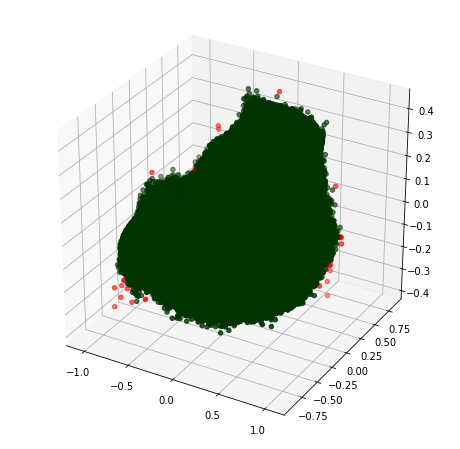

In [ ]:
import open3d as o3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
colors = np.zeros_like(pts_0) + np.array([1, 0, 0])
colors[index] = np.array([0, 0.2, 0])

ax.scatter(pts_0[:,0], pts_0[:,1], pts_0[:,2], c=colors)
plt.show()

In [ ]:
from tqdm import tqdm
import open3d as o3d

pt_clouds = []
indexs = []

for num in tqdm(range(5, ratios.shape[0])):
  with torch.no_grad():
    interpolate_samples = model.sample_interpolate(num=2000000, ratios=ratios[num:num+1])
    print(interpolate_samples.shape)

    pts, _ = order_pts(interpolate_samples.detach().cpu()[0].numpy())
    del interpolate_samples
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    _, index = pcd.remove_statistical_outlier(nb_neighbors=64, std_ratio=4.5)

    pt_clouds.append(torch.tensor(pts).unsqueeze(0))
    indexs.append(torch.tensor(index))

    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()

save_dict = {'points':torch.cat(pt_clouds, dim=0), 'index':indexs, 'ordered_index_0':ordered_index_0, 'ordered_index_1':ordered_index_1, 'ratios':ratios}
torch.save(save_dict, './hotdog-chair_1021_1.pth')

  # fig = plt.figure(figsize=(8, 8))
  # ax = fig.add_subplot(111, projection='3d')
  # ax.scatter(np_pcd[:,0], np_pcd[:,1], np_pcd[:,2])
  # plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([1, 2000000, 3])


 17%|█▋        | 1/6 [01:31<07:35, 91.06s/it]

torch.Size([1, 2000000, 3])


 33%|███▎      | 2/6 [03:02<06:06, 91.52s/it]

torch.Size([1, 2000000, 3])


 50%|█████     | 3/6 [04:35<04:35, 91.98s/it]

torch.Size([1, 2000000, 3])


 67%|██████▋   | 4/6 [06:09<03:05, 92.90s/it]

torch.Size([1, 2000000, 3])


 83%|████████▎ | 5/6 [07:42<01:32, 92.81s/it]

torch.Size([1, 2000000, 3])


100%|██████████| 6/6 [09:14<00:00, 92.43s/it]


In [ ]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [ ]:
save_dict = {'points':torch.cat(pt_clouds, dim=0), 'index':indexs, 'ordered_index_0':ordered_index_0, 'ordered_index_1':ordered_index_1}
torch.save(save_dict, './hotdog-chair_1021_0.pth')

In [9]:
dict_0 = torch.load('./hotdog-chair_1021_0.pth')
dict_1 = torch.load('./hotdog-chair_1021_1.pth')
dict_ = {'points':torch.cat([dict_0['points'], dict_1['points']], dim=0), 'index':dict_0['index']+dict_1['index'], 'ordered_index_0':ordered_index_0, 'ordered_index_1':ordered_index_1, 'ratios':ratios}
torch.save(dict_, './hotdog-chair_1021.pth')

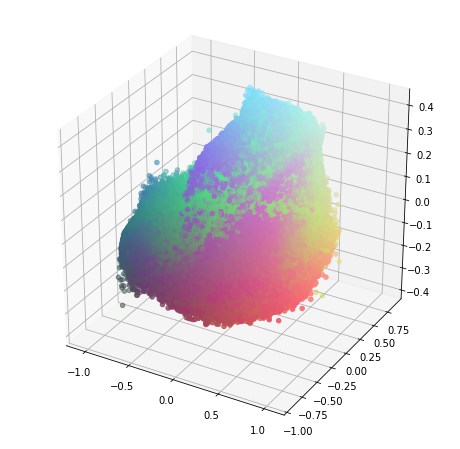

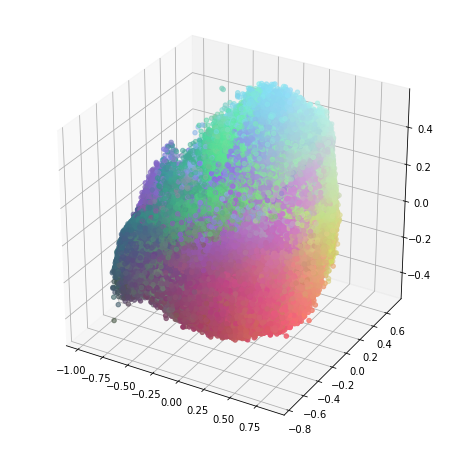

In [ ]:
pts_a = order_pts(np_pts[0])
pts_b = order_pts(np_pts[1])
max_cor = np.max(pts_a, axis=0)
min_cor = np.min(pts_a, axis=0)
eps = 0.2
colors = (pts_a - min_cor) / (max_cor - min_cor) * (1-eps) + eps

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_a[index_0,0], pts_a[index_0,1], pts_a[index_0,2], c=colors[index_0])
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_b[index_0,0], pts_b[index_0,1], pts_b[index_0,2], c=colors[index_0])
plt.show()